# Day 1: GARCH(1,1) Model

---

### 🎯 Learning Objectives
- Understand volatility clustering and GARCH motivation
- Implement GARCH(1,1) model
- Interpret GARCH parameters
- Forecast volatility


---**High persistence (α + β > 0.95) means volatility shocks decay slowly.**

### Key Insight

### 📈 Why GARCH Matters in Trading

| α + β | Total persistence | < 1 (stationarity) |

**Volatility is NOT constant.** GARCH captures time-varying volatility.| β (beta) | Persistence of volatility | 0.80 - 0.95 |

| α (alpha) | Reaction to new shocks | 0.05 - 0.15 |

### Key Formula| ω (omega) | Long-run variance baseline | Small positive |

$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$|-----------|---------|---------------|

| Parameter | Meaning | Typical Value |

### Trading Applications

### Parameter Interpretation

| Application | How GARCH Helps |

|-------------|----------------|| **Risk Management** | Real-time risk monitoring |

| **VaR Calculation** | Dynamic risk estimates || **Position Sizing** | Adjust for current volatility |
| **Option Pricing** | Forecast implied vol |

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from arch import arch_model
from scipy import stats
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252  # Trading days per year

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1256 days


## 1. Volatility Clustering Evidence

| Clusters persist | Can forecast near-term volatility |

### 🎯 Why Volatility Clustering Matters| Low vol follows low vol | Reduce hedging costs in calm periods |

| High vol follows high vol | Increase VaR in volatile periods |

**Large price moves tend to follow large price moves (of either sign).**|-------------|--------------------|

| Observation | Trading Implication |

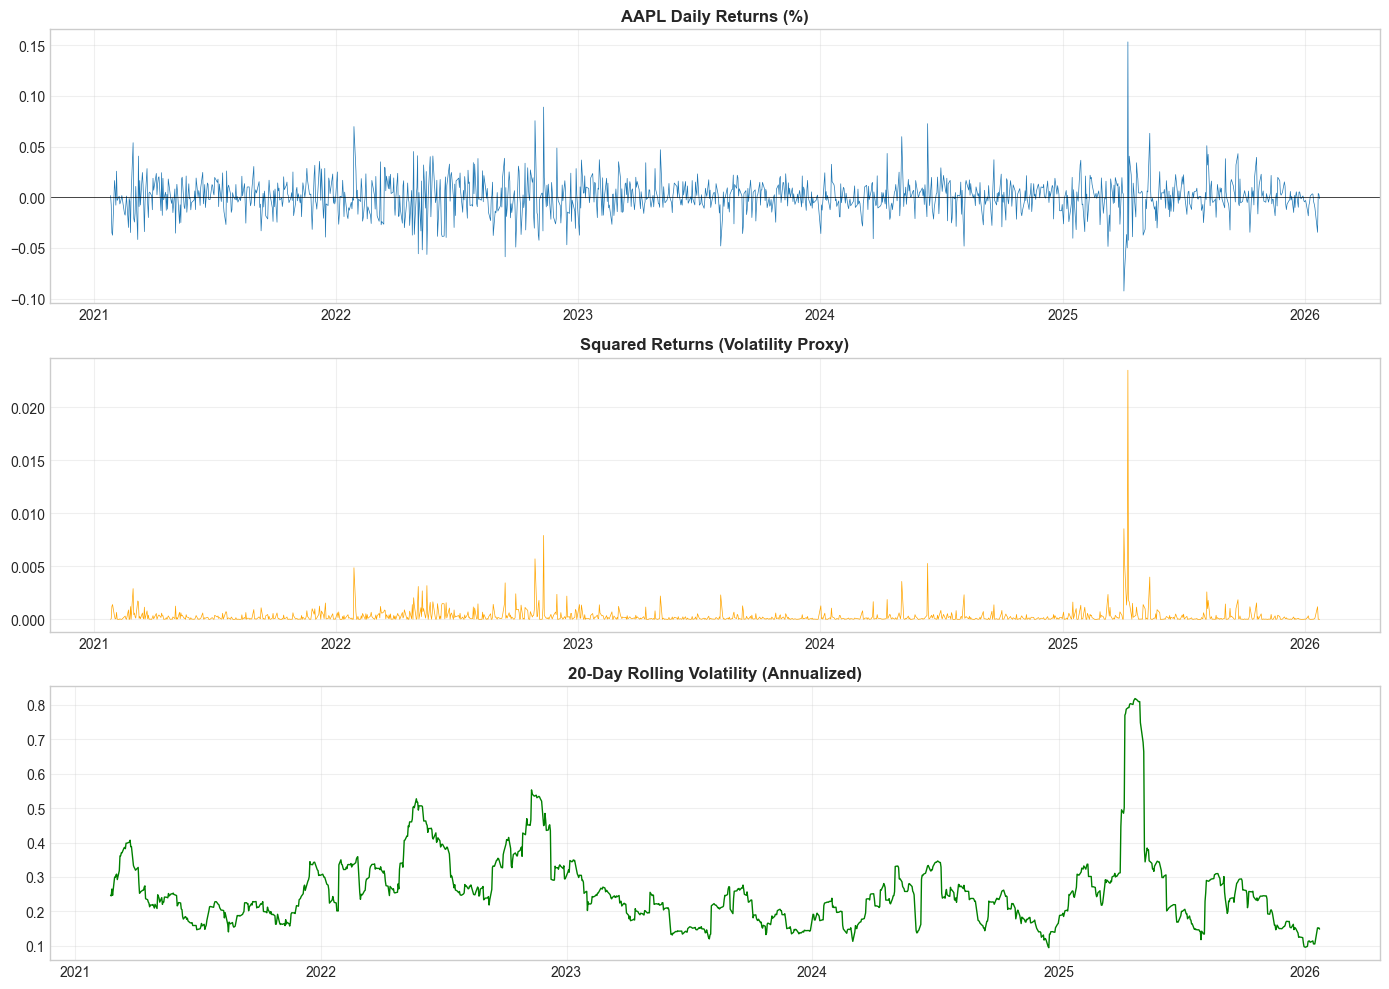


💡 Observation: Large returns cluster together - this is volatility clustering!


In [2]:
# Select a stock for analysis
stock = 'AAPL'
stock_returns = returns[stock].dropna()

# Plot returns and squared returns
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Returns
ax1 = axes[0]
ax1.plot(stock_returns, linewidth=0.5)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_title(f'{stock} Daily Returns (%)', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Squared returns (volatility proxy)
ax2 = axes[1]
ax2.plot(stock_returns**2, linewidth=0.5, color='orange')
ax2.set_title('Squared Returns (Volatility Proxy)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Rolling volatility
ax3 = axes[2]
rolling_vol = stock_returns.rolling(20).std() * np.sqrt(TRADING_DAYS)
ax3.plot(rolling_vol, linewidth=1, color='green')
ax3.set_title('20-Day Rolling Volatility (Annualized)', fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observation: Large returns cluster together - this is volatility clustering!")


ARCH LM TEST
LM Statistic: 110.6654
P-value: 0.000000

Conclusion: ARCH effects present


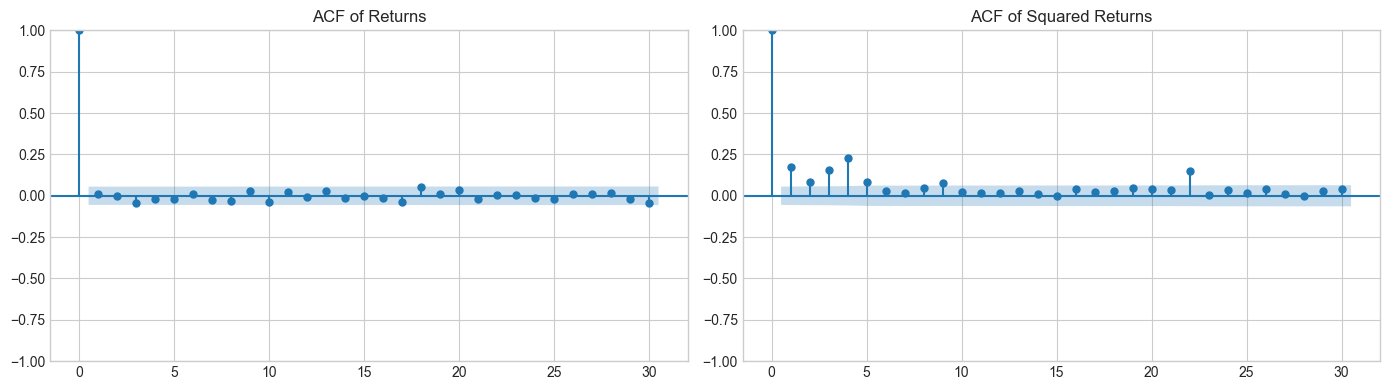


💡 Squared returns show significant autocorrelation - confirms volatility clustering


In [3]:
# Test for ARCH effects
from statsmodels.stats.diagnostic import het_arch

# ARCH LM Test
arch_test = het_arch(stock_returns)

print("\n" + "="*60)
print("ARCH LM TEST")
print("="*60)
print(f"LM Statistic: {arch_test[0]:.4f}")
print(f"P-value: {arch_test[1]:.6f}")
print(f"\nConclusion: {'ARCH effects present' if arch_test[1] < 0.05 else 'No ARCH effects'}")

# ACF of squared returns
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(stock_returns, ax=axes[0], lags=30, title='ACF of Returns')
plot_acf(stock_returns**2, ax=axes[1], lags=30, title='ACF of Squared Returns')

plt.tight_layout()
plt.show()

print("\n💡 Squared returns show significant autocorrelation - confirms volatility clustering")

## 2. Fit GARCH(1,1) Model

In [4]:
# Fit GARCH(1,1)
model = arch_model(stock_returns, vol='GARCH', p=1, q=1, mean='Constant')
result = model.fit(disp='off')

print("\n" + "="*60)
print("GARCH(1,1) MODEL RESULTS")
print("="*60)
print(result.summary())


GARCH(1,1) MODEL RESULTS
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3386.86
Distribution:                  Normal   AIC:                          -6765.73
Method:            Maximum Likelihood   BIC:                          -6745.19
                                        No. Observations:                 1255
Date:                Sat, Jan 24 2026   Df Residuals:                     1254
Time:                        11:19:27   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0498e-03  4.879e-04

In [5]:
# Extract and interpret parameters
omega = result.params['omega']
alpha = result.params['alpha[1]']
beta = result.params['beta[1]']

print("\n" + "="*60)
print("PARAMETER INTERPRETATION")
print("="*60)

print(f"\nω (omega): {omega:.6f}")
print(f"α (alpha): {alpha:.4f} - Impact of recent shock")
print(f"β (beta):  {beta:.4f} - Persistence of past variance")

# Derived quantities
persistence = alpha + beta
unconditional_var = omega / (1 - alpha - beta)
unconditional_vol = np.sqrt(unconditional_var)

# Half-life
if persistence < 1:
    half_life = np.log(0.5) / np.log(persistence)
else:
    half_life = float('inf')

print(f"\nDerived Quantities:")
print(f"   Persistence (α + β): {persistence:.4f}")
print(f"   Unconditional Variance: {unconditional_var:.4f}")
print(f"   Unconditional Vol (daily %): {unconditional_vol:.2f}%")
print(f"   Unconditional Vol (annual %): {unconditional_vol * np.sqrt(TRADING_DAYS):.2f}%")
print(f"   Half-life (days): {half_life:.1f}")

print(f"\n💡 Interpretation:")
print(f"   - High β ({beta:.2f}) = slow decay of volatility shocks")
print(f"   - Persistence close to 1 = long memory in volatility")
print(f"   - Half-life = {half_life:.0f} days for shock to decay 50%")


PARAMETER INTERPRETATION

ω (omega): 0.000009
α (alpha): 0.0664 - Impact of recent shock
β (beta):  0.9019 - Persistence of past variance

Derived Quantities:
   Persistence (α + β): 0.9683
   Unconditional Variance: 0.0003
   Unconditional Vol (daily %): 0.02%
   Unconditional Vol (annual %): 0.27%
   Half-life (days): 21.5

💡 Interpretation:
   - High β (0.90) = slow decay of volatility shocks
   - Persistence close to 1 = long memory in volatility
   - Half-life = 21 days for shock to decay 50%


## 3. Conditional Volatility

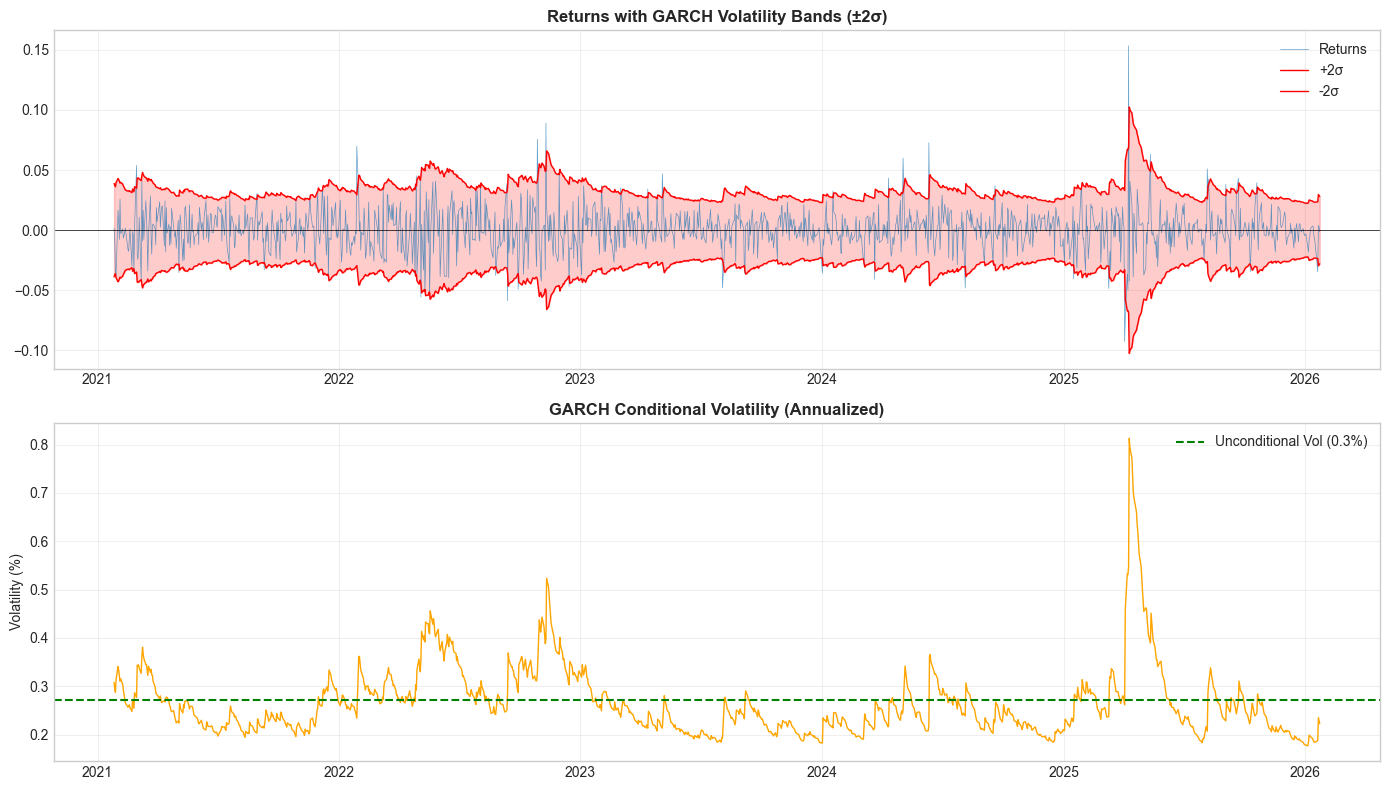

In [6]:
# Get conditional volatility
cond_vol = result.conditional_volatility

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Returns with volatility bands
ax1 = axes[0]
ax1.plot(stock_returns.index, stock_returns.values, linewidth=0.5, alpha=0.7, label='Returns')
ax1.plot(cond_vol.index, 2*cond_vol.values, 'r-', linewidth=1, label='+2σ')
ax1.plot(cond_vol.index, -2*cond_vol.values, 'r-', linewidth=1, label='-2σ')
ax1.fill_between(cond_vol.index, -2*cond_vol.values, 2*cond_vol.values, alpha=0.2, color='red')
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_title('Returns with GARCH Volatility Bands (±2σ)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Conditional volatility
ax2 = axes[1]
ax2.plot(cond_vol.index, cond_vol.values * np.sqrt(TRADING_DAYS), linewidth=1, color='orange')
ax2.axhline(unconditional_vol * np.sqrt(TRADING_DAYS), color='green', linestyle='--', 
           label=f'Unconditional Vol ({unconditional_vol * np.sqrt(TRADING_DAYS):.1f}%)')
ax2.set_title('GARCH Conditional Volatility (Annualized)', fontweight='bold')
ax2.set_ylabel('Volatility (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Volatility Forecasting


VOLATILITY FORECAST (20 DAYS)
Day    Variance     Vol (daily)  Vol (ann.)  
---------------------------------------------
h=1    0.0002       0.01        % 0.22        %
h=2    0.0002       0.01        % 0.22        %
h=3    0.0002       0.01        % 0.22        %
h=4    0.0002       0.01        % 0.22        %
h=5    0.0002       0.01        % 0.22        %
h=6    0.0002       0.01        % 0.23        %
h=7    0.0002       0.01        % 0.23        %
h=8    0.0002       0.01        % 0.23        %
h=9    0.0002       0.01        % 0.23        %
h=10   0.0002       0.01        % 0.23        %
h=11   0.0002       0.01        % 0.23        %
h=12   0.0002       0.01        % 0.23        %
h=13   0.0002       0.01        % 0.24        %
h=14   0.0002       0.01        % 0.24        %
h=15   0.0002       0.02        % 0.24        %
h=16   0.0002       0.02        % 0.24        %
h=17   0.0002       0.02        % 0.24        %
h=18   0.0002       0.02        % 0.24        %
h=19   0.0002

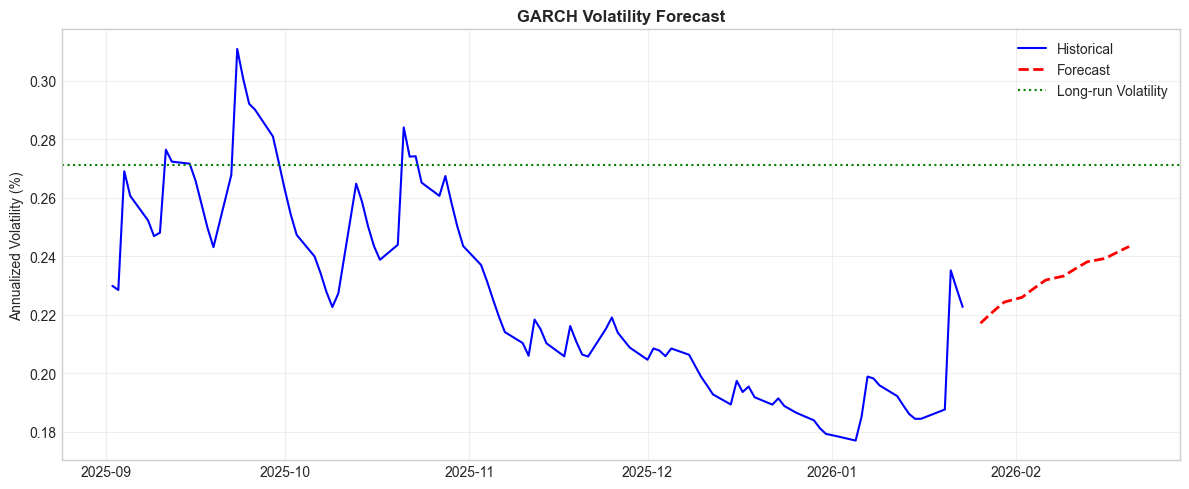


💡 Volatility forecast converges to unconditional level over time


In [7]:
# Forecast volatility
forecast_horizon = 20
forecast = result.forecast(horizon=forecast_horizon)

# Extract forecasted variance
forecast_variance = forecast.variance.iloc[-1]
forecast_vol = np.sqrt(forecast_variance)

print("\n" + "="*60)
print(f"VOLATILITY FORECAST ({forecast_horizon} DAYS)")
print("="*60)
print(f"{'Day':<6} {'Variance':<12} {'Vol (daily)':<12} {'Vol (ann.)':<12}")
print("-"*45)

for i, (var, vol) in enumerate(zip(forecast_variance, forecast_vol), 1):
    print(f"h={i:<4} {var:<12.4f} {vol:<12.2f}% {vol*np.sqrt(TRADING_DAYS):<12.2f}%")

# Plot forecast
fig, ax = plt.subplots(figsize=(12, 5))

# Historical
hist_vol_ann = cond_vol * np.sqrt(TRADING_DAYS)
ax.plot(hist_vol_ann.iloc[-100:], label='Historical', color='blue')

# Forecast
forecast_dates = pd.date_range(start=cond_vol.index[-1], periods=forecast_horizon+1, freq='B')[1:]
forecast_vol_ann = forecast_vol * np.sqrt(TRADING_DAYS)
ax.plot(forecast_dates, forecast_vol_ann, 'r--', linewidth=2, label='Forecast')

# Unconditional
ax.axhline(unconditional_vol * np.sqrt(TRADING_DAYS), color='green', linestyle=':', 
          label='Long-run Volatility')

ax.set_title('GARCH Volatility Forecast', fontweight='bold')
ax.set_ylabel('Annualized Volatility (%)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Volatility forecast converges to unconditional level over time")

## 5. Model Diagnostics

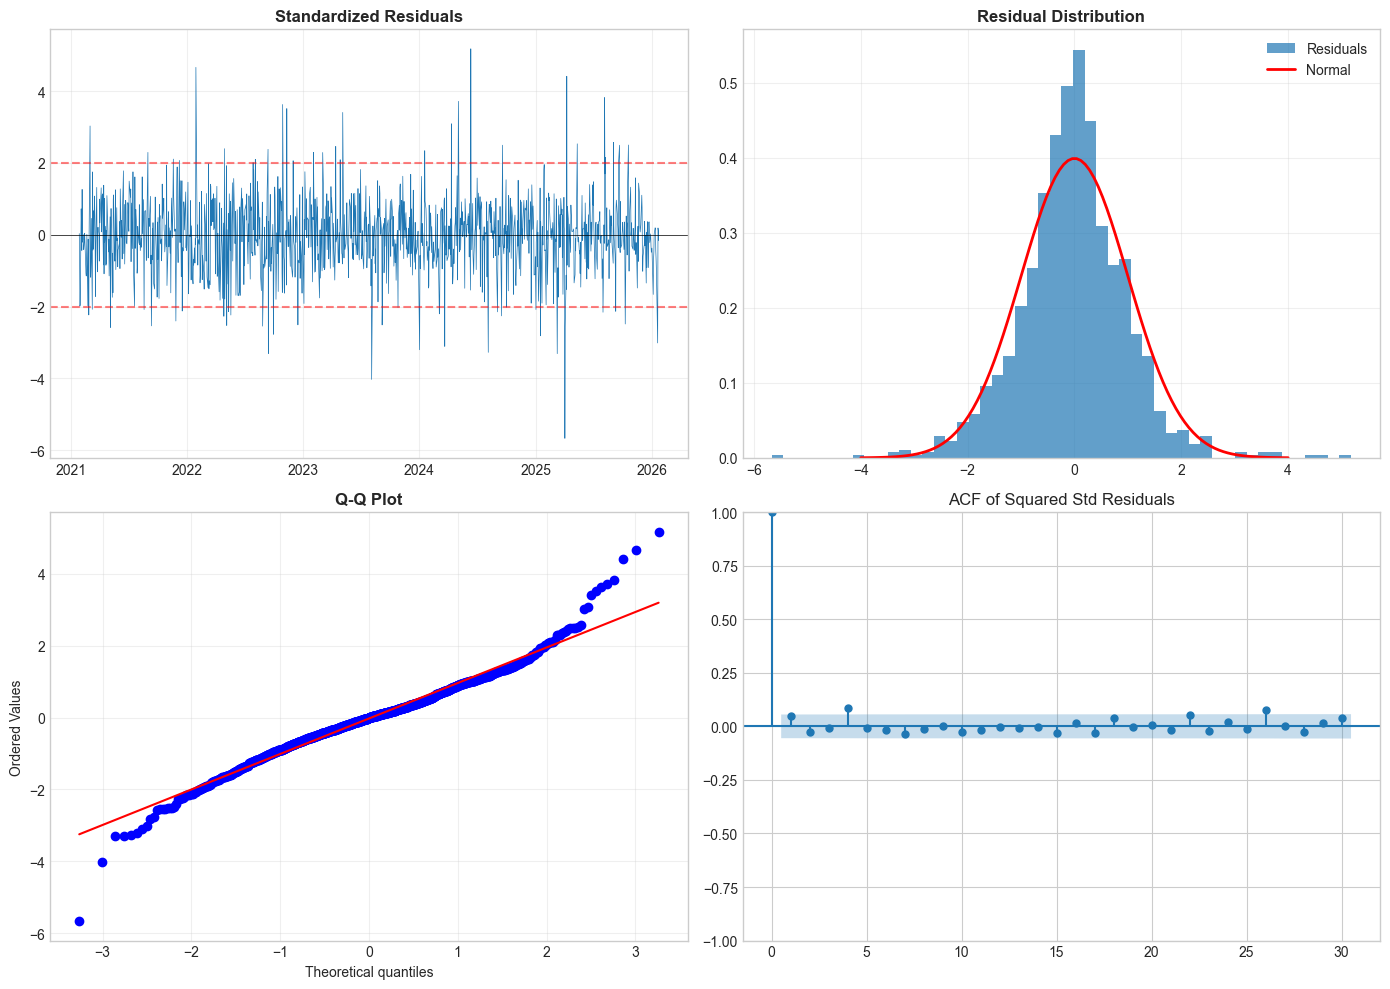


Jarque-Bera Test: Statistic=388.37, p-value=0.000000
Conclusion: Residuals are not normally distributed


In [8]:
# Standardized residuals
std_resid = result.std_resid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Standardized residuals
ax1 = axes[0, 0]
ax1.plot(std_resid, linewidth=0.5)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axhline(2, color='red', linestyle='--', alpha=0.5)
ax1.axhline(-2, color='red', linestyle='--', alpha=0.5)
ax1.set_title('Standardized Residuals', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Histogram
ax2 = axes[0, 1]
ax2.hist(std_resid, bins=50, density=True, alpha=0.7, label='Residuals')
x = np.linspace(-4, 4, 100)
ax2.plot(x, stats.norm.pdf(x), 'r-', linewidth=2, label='Normal')
ax2.set_title('Residual Distribution', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# QQ plot
ax3 = axes[1, 0]
stats.probplot(std_resid.dropna(), dist='norm', plot=ax3)
ax3.set_title('Q-Q Plot', fontweight='bold')
ax3.grid(True, alpha=0.3)

# ACF of squared standardized residuals
ax4 = axes[1, 1]
plot_acf(std_resid**2, ax=ax4, lags=30, title='ACF of Squared Std Residuals')

plt.tight_layout()
plt.show()

# Jarque-Bera test
jb_stat, jb_pval = stats.jarque_bera(std_resid.dropna())
print(f"\nJarque-Bera Test: Statistic={jb_stat:.2f}, p-value={jb_pval:.6f}")
print(f"Conclusion: Residuals are {'not ' if jb_pval < 0.05 else ''}normally distributed")

## 6. Compare Multiple Stocks

In [9]:
# Fit GARCH to multiple stocks
test_stocks = ['AAPL', 'MSFT', 'JPM', 'XOM', 'GS']

print("\n" + "="*70)
print("GARCH(1,1) COMPARISON")
print("="*70)
print(f"{'Stock':<8} {'ω':<12} {'α':<10} {'β':<10} {'α+β':<10} {'Uncond Vol':<12}")
print("-"*70)

garch_results = {}
for s in test_stocks:
    if s in returns.columns:
        model = arch_model(returns[s].dropna(), vol='GARCH', p=1, q=1)
        res = model.fit(disp='off')
        garch_results[s] = res
        
        omega = res.params['omega']
        alpha = res.params['alpha[1]']
        beta = res.params['beta[1]']
        persist = alpha + beta
        uncond_vol = np.sqrt(omega / (1 - alpha - beta)) * np.sqrt(TRADING_DAYS)
        
        print(f"{s:<8} {omega:<12.6f} {alpha:<10.4f} {beta:<10.4f} {persist:<10.4f} {uncond_vol:<12.2f}%")


GARCH(1,1) COMPARISON
Stock    ω            α          β          α+β        Uncond Vol  
----------------------------------------------------------------------
AAPL     0.000009     0.0664     0.9019     0.9683     0.27        %
MSFT     0.000003     0.0373     0.9507     0.9880     0.26        %
JPM      0.000070     0.1000     0.6000     0.7000     0.24        %
GS       0.000092     0.2013     0.5000     0.7013     0.28        %


## Key Takeaways

1. **GARCH captures volatility clustering** - large returns followed by large returns
2. **Parameters**: α measures shock impact, β measures persistence
3. **Persistence (α+β)** typically close to 1 for financial data
4. **Half-life** measures how long shocks take to decay
5. **Forecasts** converge to unconditional volatility

### GARCH(1,1) Formula
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

---
*Next: Day 2 - EGARCH for Leverage Effects*

## 🔴 PROS & CONS: GARCH

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [10]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - GARCH Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-24 11:19

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $248.04
   GOOGL: $327.93
   GS: $918.88
   JPM: $297.72
   MSFT: $465.95

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -9.41%
   🟢 GOOGL: +4.41%
   🟢 GS: +0.89%
   🔴 JPM: -9.15%
   🔴 MSFT: -4.52%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟡 NEUTRAL - Hold current positions
   GS: 🟡 NEUTRAL - Hold current positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🟡 NEUTRAL - Hold current positions

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
